In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from photutils.detection import find_peaks
from scipy.ndimage import rotate
import os
# from astropy.modeling.models import Gaussian2D # Not used in current code
# from scipy.optimize import curve_fit # Not used in current code
import math

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import fnmatch
import os
from astropy.io import fits
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
from scipy import interpolate
import cv2
import math
from textwrap import wrap
import scipy.ndimage as ndimage
from matplotlib.gridspec import GridSpec
from matplotlib import colors
import functions as f
import pandas as pd
from scipy.optimize import curve_fit
from numpy import asarray as ar,exp

def plot_with_same_color(data, keys, labels,title,star,lim1,arcsinh,cameras):
    #min and max values setted manually here to 0 and 1
    num_keys = len(keys)
    ncols = int(np.ceil(np.sqrt(num_keys)))  # Adjust the number of rows as needed
    nrows = int(np.ceil(num_keys / ncols))
    fig = plt.figure(figsize=(12, 8))
    data_arcshin={}
    for idx, key in enumerate(keys):
        if arcsinh==True:
            data_arcshin[key] =np.arcsinh(data[key])
        else:
            data_arcshin[key] = data[key]
    # Using GridSpec to create a more flexible subplot layout

    gs = GridSpec(nrows, ncols, figure=fig, wspace=0.1, hspace=0.25)
    # Calculate vmin and vmax for all images
    n = data_arcshin[key].shape[0]
    vmin = np.min([np.min(data_arcshin[key][int(n/2-lim1):int(n/2+lim1), int(n/2-lim1):int(n/2+lim1)]) for key in keys])
    vmax = np.max([np.max(data_arcshin[key][int(n/2-lim1):int(n/2+lim1), int(n/2-lim1):int(n/2+lim1)]) for key in keys])

    for idx, key in enumerate(keys):
        if cameras[idx]=='IRDIS':
            ps=12.27
            lim=lim1*1.0
        else:
            ps=3.6#6.8
            lim=lim1*12.27/3.6

        ax = fig.add_subplot(gs[idx])
        n = data_arcshin[key].shape[0]
        d = (n-1) * ps / 2
        im = ax.imshow(data_arcshin[key], extent=(-d, d, -d, d), vmin=vmin, vmax=vmax,origin='lower')
        #plotting contour
        if arcsinh:
            levels=[np.arcsinh(np.max(data[key])/64),np.arcsinh(np.max(data[key])/32),np.arcsinh(np.max(data[key])/16),np.arcsinh(np.max(data[key])/8),np.arcsinh(np.max(data[key])/4),np.arcsinh(np.max(data[key])/2)]
        else:
            levels=[np.max(data[key])/64,np.max(data[key])/32,np.max(data[key])/16,np.max(data[key])/8,np.max(data[key])/4,np.max(data[key])/2]
        CS=ax.contour(data_arcshin[key], levels=levels,colors=['black', 'brown', 'red','purple','pink','white'], extent=(-d, d, -d, d))
        ax.clabel(CS, inline=True, fontsize=10)

        ax.set_title(labels[key])
        ax.set_xlabel('mas')
        ax.set_ylabel('mas')
        ax.set_xlim(-lim * ps, lim * ps)
        ax.set_ylim(-lim * ps, lim * ps)
        ax.label_outer()

    # Create a common colorbar for all images
    cax = fig.add_axes([0.95, 0.22, 0.02, 0.55])  # Adjust the position of colorbar as needed
    cb = fig.colorbar(im, cax=cax, orientation='vertical')
    fig.suptitle(star+' '+title, fontsize=16)#,y=0.85)

    #specific_folder=figfolder+'models/'
    #try:
    # Create target Directory
    #   os.mkdir(specific_folder)
    #except FileExistsError:
    #    print("Directory " , specific_folder,  " already exists")

    #plt.savefig(specific_folder +star+'_'+title+".jpeg",bbox_inches='tight', pad_inches=0.1)
    #plt.show()

def LoadImage(dirdat,filename):
    dir =dirdat
    psfile =  filename
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, psfile):
            hdulPSF = fits.open(dir + file)
            fit = hdulPSF[0].data


    return fit

def LoadImage_dec (dir,annulus):

    files = os.listdir(dir)
    for fil in files:
        if fnmatch.fnmatch(fil, '*'+annulus+'_decon.fits'):
            hdu = fits.open(dir+fil)
            image = hdu[0].data
            ps =3.6
            n=image.shape[0]
            d=(n-1)/2
            x = np.linspace(-d, d, n)
            y = np.linspace(-d, d, n)
            x2, y2 = np.meshgrid(x, y)
            R = np.sqrt(x2**2+y2**2)
    return image, R, x, y, d,x2,y2

def createfolder(dirName):
    try:
    # Create target Directory
       os.mkdir(dirName)
    except FileExistsError:
        print()#("Directory " , dirName ,  " already exists")

def load_I(dirdat,camera):
    dir = dirdat
    qfile = '*sci'+camera+'.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            iq = hdulq[0].data[0]
            q = hdulq[0].data[1]
            iu = hdulq[0].data[2]
            u = hdulq[0].data[3]
            n=q.shape[0]
            i=(iq+iu)/2

    return iq,iu,i

def Loadimagespsf(star,dirdat,band):
    dir = dirdat
    qfile = '*_'+band+'_I_meancombined.fits'
    files = os.listdir(dir)
    image=[]
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            with fits.open(dir + file) as hdul:
                image = hdul[0].data
                n = image.shape[0]

                print(n)
    return image, n

def plotImage(image, lim):
    n = image.shape[0]
    fig, ax = plt.subplots(figsize=(8,6))
    image = np.arcsinh(image)
    max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    ps = 3.6 #mas per pixel for zimpol
    d = n * ps / 2
    plt.imshow(image, vmin=min, vmax=max, extent=(-d, d, d, -d))
    #plt.plot(0, 0, "+", color="red")
    plt.xlim(-lim * ps, lim * ps)
    plt.ylim(-lim * ps, lim * ps)
    # ax.set_xticks(np.arange(-lim*ps, lim*ps + 1, 100))
    plt.xlabel('mas', fontsize=20)
    plt.ylabel('mas', fontsize=20)
    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=18)
    plt.colorbar()
    plt.tight_layout
    return fig, ax

def Loadimages_notdeconv(star,fittype,dirdat,band, extension):
    dir = dirdat
    qfile = star+'_'+band+'_'+fittype+extension+'.fits'
    print(qfile)
    files = os.listdir(dir)
    image=[]
    for file in files:
        if fnmatch.fnmatch(file, qfile):

            with fits.open(dir + file) as hdul:
                image = hdul[0].data
                print(image[1,4])
                n = image.shape[0]

    return image, n

def Loadimages(dirdat,band, extension):
    dir = dirdat
    qfile = band+extension+'.fits'
    files = os.listdir(dir)
    image=[]
    for file in files:
        if fnmatch.fnmatch(file, qfile):

            with fits.open(dir + file) as hdul:
                image = hdul[0].data
                n = image.shape[0]

    return image, n


In [2]:
def plot_circle_overlay(image_data, band_label, output_path, peak_x, peak_y,
                        plate_scale, separation_pixels, zoom_half_width_mas):
    """Plots an image with an azimuthal profile circle and compass + scale bar."""
    ny, nx = image_data.shape
    display_image = np.arcsinh(image_data)

    fig, ax = plt.subplots(figsize=(8, 8))

    ax.imshow(display_image, origin='lower', cmap='viridis',
              vmin=0, vmax=10,
              extent=(-nx/2 * plate_scale, nx/2 * plate_scale,
                      -ny/2 * plate_scale, ny/2 * plate_scale))

    # Circle coordinates
    theta = np.linspace(0, 2*np.pi, 360)
    circle_x_pixels = peak_x + separation_pixels * np.cos(theta)
    circle_y_pixels = peak_y + separation_pixels * np.sin(theta)
    circle_x_mas = (circle_x_pixels - nx/2) * plate_scale
    circle_y_mas = (circle_y_pixels - ny/2) * plate_scale

    ax.plot(circle_x_mas, circle_y_mas, 'w:', linewidth=2, label=f'{separation_pixels * plate_scale:.0f} mas circle')
    ax.plot(0, 0, 'rx', markersize=10, label='Image Center')

    ax.set_xlim(-zoom_half_width_mas, zoom_half_width_mas)
    ax.set_ylim(-zoom_half_width_mas, zoom_half_width_mas)
    ax.set_title(f'Deconvolved AR Pup {band_label} band', fontsize=16)
    ax.grid(False)

    # Compass
    padding = 0.05 * zoom_half_width_mas
    arrow_length = 0.15 * zoom_half_width_mas
    head_width = 0.05 * arrow_length
    head_length = 0.1 * arrow_length
    base_x = zoom_half_width_mas - padding
    base_y = -zoom_half_width_mas + padding

    ax.arrow(base_x, base_y, 0, arrow_length,
             head_width=head_width, head_length=head_length,
             fc='white', ec='white', linewidth=1, zorder=10)
    ax.text(base_x, base_y + arrow_length + 0.1 * arrow_length,
            'N', color='white', ha='center', va='bottom', fontsize=10)

    ax.arrow(base_x, base_y, -arrow_length, 0,
             head_width=head_width, head_length=head_length,
             fc='white', ec='white', linewidth=1, zorder=10)
    ax.text(base_x - arrow_length - 0.2 * arrow_length, base_y,
            'E', color='white', ha='right', va='center', fontsize=10)

    # Scale bar
    scale_length = 100
    pad_x = 0.05 * zoom_half_width_mas
    pad_y = 0.08 * zoom_half_width_mas
    bar_x = -zoom_half_width_mas + pad_x
    bar_y = -zoom_half_width_mas + pad_y

    ax.plot([bar_x, bar_x + scale_length],
            [bar_y, bar_y], 'w-', linewidth=3, zorder=10)
    ax.text(bar_x + scale_length / 2, bar_y - (0.02 * zoom_half_width_mas),
            f'{scale_length} mas',
            color='white', ha='center', va='top', fontsize=10)

    plt.tight_layout()
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    plt.savefig(output_path, dpi=300)
    plt.show()
    plt.close(fig)

In [3]:
def plot_circle_overlay(image_data, band_label, output_path, peak_x, peak_y,
                        plate_scale, separation_pixels, zoom_half_width_mas):
    """Plots an image with an azimuthal profile circle and compass + scale bar."""
    ny, nx = image_data.shape
    display_image = np.arcsinh(image_data)

    fig, ax = plt.subplots(figsize=(8, 8))

    ax.imshow(display_image, origin='lower', cmap='viridis',
              vmin=0, vmax=9,
              extent=(-nx/2 * plate_scale, nx/2 * plate_scale,
                      -ny/2 * plate_scale, ny/2 * plate_scale))

    # Circle coordinates
    theta = np.linspace(0, 2*np.pi, 360)
    circle_x_pixels = peak_x + separation_pixels * np.cos(theta)
    circle_y_pixels = peak_y + separation_pixels * np.sin(theta)
    circle_x_mas = (circle_x_pixels - nx/2) * plate_scale
    circle_y_mas = (circle_y_pixels - ny/2) * plate_scale

    ax.plot(circle_x_mas, circle_y_mas, 'w:', linewidth=2, label=f'{separation_pixels * plate_scale:.0f} mas circle')
    ax.plot(0, 0, 'rx', markersize=10, label='Image Center')

    ax.set_xlim(-zoom_half_width_mas, zoom_half_width_mas)
    ax.set_ylim(-zoom_half_width_mas, zoom_half_width_mas)
    ax.set_title(f'Deconvolved AR Pup {band_label} band', fontsize=16)
    ax.grid(False)

    # Compass
    padding = 0.05 * zoom_half_width_mas
    arrow_length = 0.15 * zoom_half_width_mas
    head_width = 0.05 * arrow_length
    head_length = 0.1 * arrow_length
    base_x = zoom_half_width_mas - padding
    base_y = -zoom_half_width_mas + padding

    ax.arrow(base_x, base_y, 0, arrow_length,
             head_width=head_width, head_length=head_length,
             fc='white', ec='white', linewidth=1, zorder=10)
    ax.text(base_x, base_y + arrow_length + 0.1 * arrow_length,
            'N', color='white', ha='center', va='bottom', fontsize=10)

    ax.arrow(base_x, base_y, -arrow_length, 0,
             head_width=head_width, head_length=head_length,
             fc='white', ec='white', linewidth=1, zorder=10)
    ax.text(base_x - arrow_length - 0.2 * arrow_length, base_y,
            'E', color='white', ha='right', va='center', fontsize=10)

    # Scale bar
    scale_length = 100
    pad_x = 0.05 * zoom_half_width_mas
    pad_y = 0.08 * zoom_half_width_mas
    bar_x = -zoom_half_width_mas + pad_x
    bar_y = -zoom_half_width_mas + pad_y

    ax.plot([bar_x, bar_x + scale_length],
            [bar_y, bar_y], 'w-', linewidth=3, zorder=10)
    ax.text(bar_x + scale_length / 2, bar_y - (0.02 * zoom_half_width_mas),
            f'{scale_length} mas',
            color='white', ha='center', va='top', fontsize=10)

    plt.tight_layout()
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    plt.savefig(output_path, dpi=300)
    plt.show()
    plt.close(fig)

In [24]:
import numpy as np

def crop_centered(image, target_height, target_width):
    """
    Crops a 2D NumPy array (image) to a specified target height and width,
    while keeping the center of the original image at the center of the cropped image.

    Args:
        image (np.ndarray): The 2D NumPy array representing the image to crop.
        target_height (int): The desired height of the cropped image.
        target_width (int): The desired width of the cropped image.

    Returns:
        np.ndarray: The cropped 2D NumPy array.
    """
    original_height, original_width = image.shape

    if target_height > original_height or target_width > original_width:
        raise ValueError("Target dimensions cannot be larger than original dimensions.")

    center_y = original_height // 2
    center_x = original_width // 2

    half_target_height = target_height // 2
    half_target_width = target_width // 2

    start_y = center_y - half_target_height
    end_y = center_y + half_target_height

    start_x = center_x - half_target_width
    end_x = center_x + half_target_width

    # Adjust for potential off-by-one errors due to integer division
    if (end_y - start_y) < target_height:
        if start_y > 0:
            start_y -= 1
        else:
            end_y += 1

    if (end_x - start_x) < target_width:
        if start_x > 0:
            start_x -= 1
        else:
            end_x += 1

    cropped_image = image[start_y:end_y, start_x:end_x]
    return cropped_image


In [ ]:

# --- Helper Functions ---
def load_fits_image(filepath):
    """Loads a FITS image and returns data and header."""
    with fits.open(filepath) as hdul:
        data = hdul[0].data
        header = hdul[0].header
    return data, header

def cart2polar_for_mask_defining(X, Y):
    """Converts Cartesian coordinates to polar (radius, position angle)."""
    r = np.sqrt(X**2 + Y**2)
    # Position angle: 0 at North (Y-axis), increasing East (X-axis).
    # np.arctan2(y, x) gives angle from positive x-axis, increasing counter-clockwise.
    # Convert to astronomical convention: 0 North, increasing East.
    # Adjust for quadrant as np.arctan2 returns -pi to pi.
    pa = np.degrees(np.arctan2(-X, Y)) # X for East, Y for North
    pa[pa < 0] += 360 # Ensure 0-360 range
    return r, pa


### DK Ertiel 2016

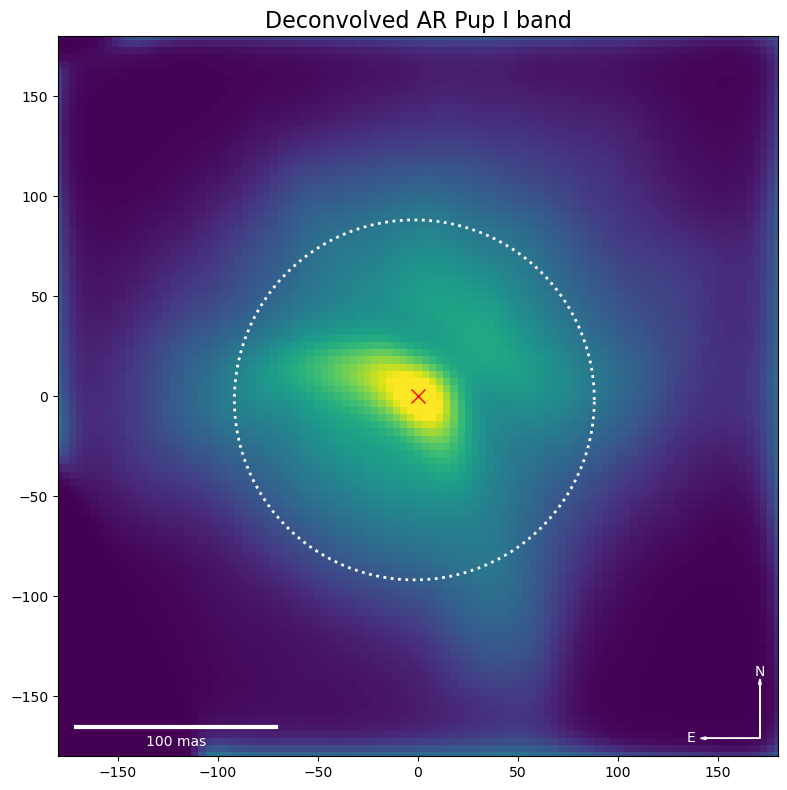

In [20]:
zoom_half_width_mas = 250

fits_file_I = '/Users/aksitadeo/PycharmProjects/Ertel/MQ data/PAGB/PAGB_CODES/PAGB_CODES/AR_Pup_DK_Ertel/AR_Pup_old/files_julien/ZIMPOL_decon.fits'

plate_scale_mas_per_px = 3.6 # mas/pixel
separation_pixels = 25     # Distance from peak for azimuthal profile
separation_mas = separation_pixels * plate_scale_mas_per_px
photometric_zero_point = 24.8 # Placeholder: magnitude zero point

try:
    I_data, I_header = load_fits_image(fits_file_I)
    I_data = rotate(I_data, angle=0, reshape=False, order=3)

except FileNotFoundError as e:
    print(f"Error: FITS file not found. Please check paths: {e}")
    exit()

# Get image dimensions (assuming I and V have same dimensions)
ny, nx = I_data.shape
if ny != nx:
    print("Warning: Image is not square. Code assumes square images.")

coords = find_peaks(I_data, np.max(I_data)*0.5, npeaks=1) # find_peaks threshold needs adjusting
if len(coords) < 0:
    peak_y, peak_x = int(coords['y_peak'][0]), int(coords['x_peak'][0])
else:
    print("Warning: Could not find a clear peak in I-band. Assuming image center for now.")
    peak_y, peak_x = ny // 2, nx // 2

# Create coordinate grids centered on the peak
x_coords = np.arange(nx) - peak_x
y_coords = np.arange(ny) - peak_y
X_grid, Y_grid = np.meshgrid(x_coords, y_coords)

# Convert to polar coordinates relative to the peak
radii, position_angles = cart2polar_for_mask_defining(X_grid, Y_grid)

# --- Extract Azimuthal Profiles ---
# Find pixels that are within a small radial tolerance around the desired separation
annulus_tolerance = 2 # pixels, defines the half-width of the annulus
azimuthal_mask = (radii >= separation_pixels - annulus_tolerance) & \
                 (radii < separation_pixels + annulus_tolerance)

# Extract data points within the annulus for I-band
# I_data = crop_centered(I_data,244,244)
I_annulus_values = I_data[azimuthal_mask]
pa_annulus_values = position_angles[azimuthal_mask]

# Sort by position angle
sort_indices = np.argsort(pa_annulus_values)
pa_sorted = pa_annulus_values[sort_indices]
I_sorted = I_annulus_values[sort_indices]

# --- Convert to Surface Brightness (Magnitude/as^2) ---
pixel_area_arcsec2 = (plate_scale_mas_per_px / 1000.0)**2
floor_value = 1e-15 # very small positive number to avoid log10(0)
I_surface_brightness = -2.5 * np.log10(I_sorted/pixel_area_arcsec2) + photometric_zero_point

# --- Plotting the Azimuthal Profiles (I and V on the same graph) ---
# fig_profile, ax_profile = plt.subplots(figsize=(10, 6))
# ax_profile.plot(pa_sorted, I_surface_brightness, label='I Band (Total Intensity)', color='blue')
#
# ax_profile.set_xlabel('Position Angle East of North (deg)', fontsize=14)
# ax_profile.set_ylabel(r'Surface Brightness (mag/arcsec$^2$)', fontsize=14)
# ax_profile.set_title(f'Azimuthal Profile at {separation_mas:.0f} mas from Peak (I and V Bands)', fontsize=16)
# ax_profile.legend(fontsize=12)
# ax_profile.grid(True, linestyle=':', alpha=0.7)
# ax_profile.set_xlim(0, 360) # Ensure full 0-360 range
# ax_profile.set_xticks(np.arange(0, 361, 45)) # Ticks every 45 degrees
#
# plt.tight_layout()
# plt.show()
# plt.close(fig_profile)

# Save overlay image for I band
output_image_I = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/After_deconvv1/ZIMPOL/DKER_i_azimuthal_circle.png'
# output_image_I = output_image_with_circle.replace("v_band", "i_band")
plot_circle_overlay(I_data, 'I', output_image_I,
                    peak_x, peak_y,
                    plate_scale_mas_per_px,
                    separation_pixels,
                    180)
plt.show()

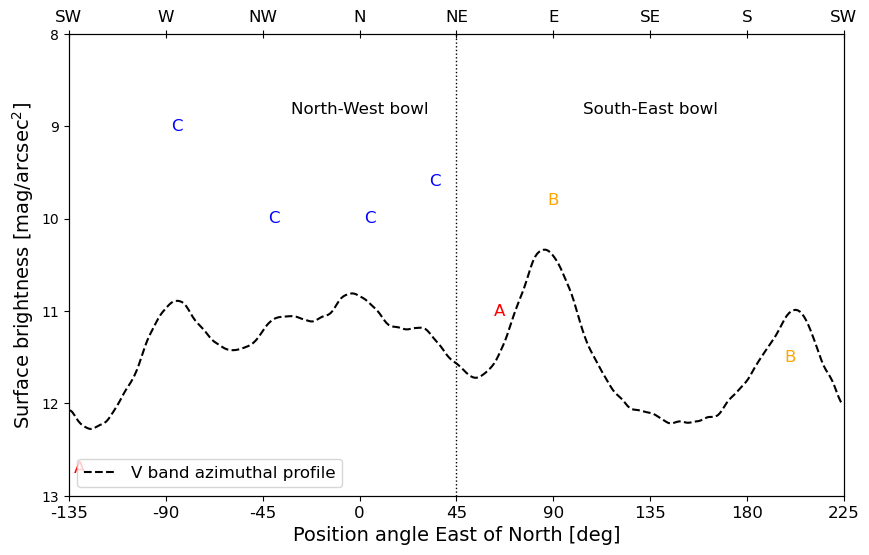

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

# --- Parameters ---
annulus_tolerance = 1
target_radius = 25
n_neighbors = 4
bin_width = 1.0
plate_scale_mas_per_px = 3.6
floor_value = 1e-15
smooth_sigma = 2  # in bins

# --- Step 1: Mask annulus and get coordinates ---
annulus_mask = (radii >= target_radius - annulus_tolerance) & (radii <= target_radius + annulus_tolerance)
y_idx, x_idx = np.where(annulus_mask)
coords = np.vstack((x_idx, y_idx)).T

# Get flux and position angle
I_data_cp = I_data / 4.0
flux_values = I_data_cp[annulus_mask]
pa_values = position_angles[annulus_mask]

# --- Step 2: Nearest neighbor smoothing ---
tree = cKDTree(coords)
_, neighbor_indices = tree.query(coords, k=n_neighbors)
smoothed_flux = np.array([np.mean(flux_values[inds]) for inds in neighbor_indices])

# --- Step 3: Shift PAs ---
pa_shifted = np.copy(pa_values)
pa_shifted[pa_shifted > 225] -= 360

# --- Step 4: Bin by PA ---
bins = np.arange(-135, 225 + bin_width, bin_width)
bin_centers = (bins[:-1] + bins[1:]) / 2
mean_flux_per_bin = np.full_like(bin_centers, np.nan, dtype=np.float64)

for i in range(len(bins) - 1):
    mask = (pa_shifted >= bins[i]) & (pa_shifted < bins[i + 1])
    if np.any(mask):
        mean_flux_per_bin[i] = np.mean(smoothed_flux[mask])

# --- Step 5: Interpolate ---
valid = ~np.isnan(mean_flux_per_bin)
interp_func = interp1d(bin_centers[valid], mean_flux_per_bin[valid], kind='linear', fill_value='extrapolate')
mean_flux_interp = interp_func(bin_centers)

# --- Step 6: Smoothing for nicer curve ---
mean_flux_smooth = gaussian_filter1d(mean_flux_interp, sigma=smooth_sigma)

# --- Step 7: Convert to surface brightness ---
pixel_area_arcsec2 = (plate_scale_mas_per_px / 1000.0) ** 2
ZP_I = 24.8
I_sb_profile = -2.5 * np.log10(np.maximum(mean_flux_smooth, floor_value) / pixel_area_arcsec2) + ZP_I

# --- Step 8: Plot ---
fig, ax_profile = plt.subplots(figsize=(10, 6))
ax_profile.plot(bin_centers, I_sb_profile, color='black', linestyle='--', label='V band azimuthal profile')

# Axes setup
ax_profile.set_ylabel(r'Surface brightness [mag/arcsec$^2$]', fontsize=14)
ax_profile.set_ylim(8, 13)
ax_profile.invert_yaxis()
ax_profile.set_xlim(-135, 225)
ax_profile.set_xlabel('Position angle East of North [deg]', fontsize=14)
tick_pos = [-135, -90, -45, 0, 45, 90, 135, 180, 225]
ax_profile.set_xticks(tick_pos)
ax_profile.set_xticklabels([str(p) for p in tick_pos], fontsize=12)

# Cardinal direction top axis
ax_top = ax_profile.twiny()
ax_top.set_xlim(ax_profile.get_xlim())
ax_top.set_xticks(tick_pos)
ax_top.set_xticklabels(['SW', 'W', 'NW', 'N', 'NE', 'E', 'SE', 'S', 'SW'], fontsize=12)
ax_top.set_xlabel('')
ax_top.tick_params(axis='x', direction='inout', length=6)

# Annotations
ax_profile.axvline(x=45, color='black', linestyle=':', linewidth=1)
ax_profile.text(0, 8.9, 'North-West bowl', ha='center', va='bottom', fontsize=12)
ax_profile.text(135, 8.9, 'South-East bowl', ha='center', va='bottom', fontsize=12)

# Feature labels
ax_profile.text(65, 11, 'A', color='red', ha='center', va='center', fontsize=12)
ax_profile.text(-130, 12.7, 'A', color='red', ha='center', va='center', fontsize=12)
ax_profile.text(90, 9.8, 'B', color='orange', ha='center', va='center', fontsize=12)
ax_profile.text(200, 11.5, 'B', color='orange', ha='center', va='center', fontsize=12)
ax_profile.text(-85, 9, 'C', color='blue', ha='center', va='center', fontsize=12)
ax_profile.text(-40, 10, 'C', color='blue', ha='center', va='center', fontsize=12)
ax_profile.text(5, 10, 'C', color='blue', ha='center', va='center', fontsize=12)
ax_profile.text(35, 9.6, 'C', color='blue', ha='center', va='center', fontsize=12)

ax_profile.legend(fontsize=12, loc='lower left')
ax_profile.grid(False)
ax_profile.set_facecolor('white')

plt.show()


### 2016 DEO ANALYSIS #####

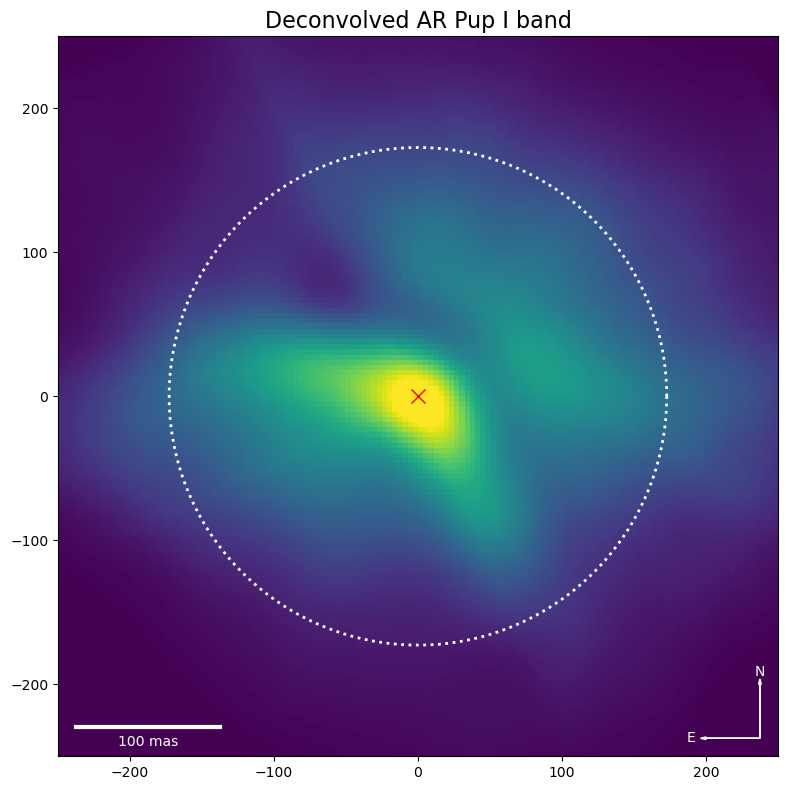

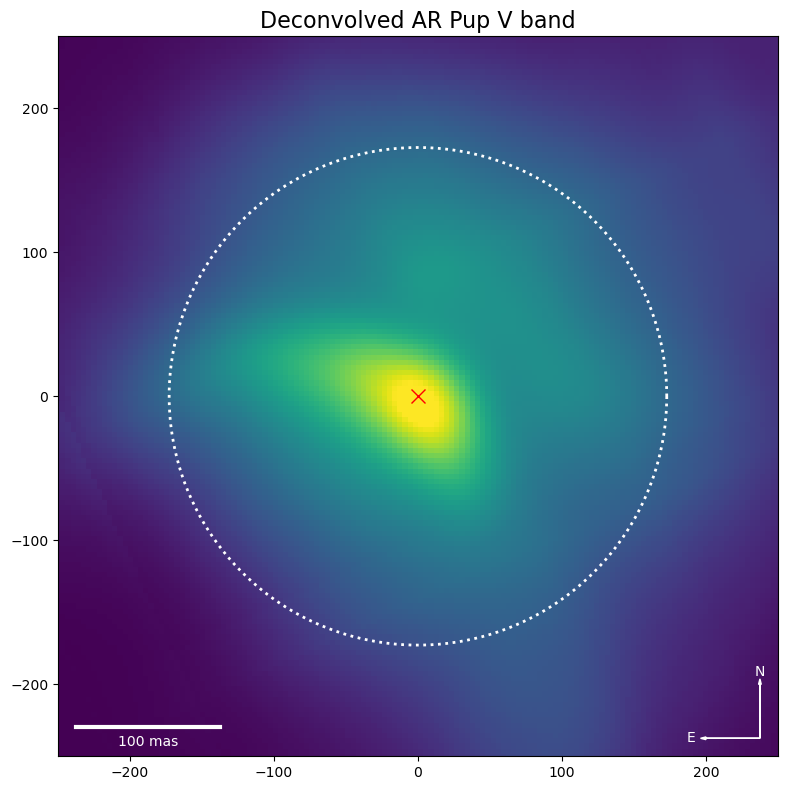

In [26]:
zoom_half_width_mas = 250

fits_file_I = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/Deconvolution_corr_telv1/ZIMPOLv2/deconvolved_I/02.SCI_AR_Pup_I_decon.fits'
fits_file_V = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/Deconvolution_corr_telv1/ZIMPOL/deconvolved_I/02.SCI_AR_Pup_V_decon.fits'

plate_scale_mas_per_px = 3.6 # mas/pixel
separation_pixels = 48     # Distance from peak for azimuthal profile
separation_mas = separation_pixels * plate_scale_mas_per_px
photometric_zero_point = 24.8 # Placeholder: magnitude zero point

I_data, I_header = load_fits_image(fits_file_I)
I_data = rotate(I_data, angle=0, reshape=False, order=3)

V_data, V_header = load_fits_image(fits_file_V)
V_data = rotate(V_data, angle=0, reshape=False, order=3)

# Get image dimensions (assuming I and V have same dimensions)
ny, nx = I_data.shape
if ny != nx:
    print("Warning: Image is not square. Code assumes square images.")

coords = find_peaks(I_data, np.max(I_data)*0.5, npeaks=1) # find_peaks threshold needs adjusting
if len(coords) < 0:
    peak_y, peak_x = int(coords['y_peak'][0]), int(coords['x_peak'][0])
else:
    print("Warning: Could not find a clear peak in I-band. Assuming image center for now.")
    peak_y, peak_x = ny // 2, nx // 2

# Create coordinate grids centered on the peak
x_coords = np.arange(nx) - peak_x
y_coords = np.arange(ny) - peak_y
X_grid, Y_grid = np.meshgrid(x_coords, y_coords)

# Convert to polar coordinates relative to the peak
radii, position_angles = cart2polar_for_mask_defining(X_grid, Y_grid)

# --- Extract Azimuthal Profiles ---
# Find pixels that are within a small radial tolerance around the desired separation
annulus_tolerance = 2 # pixels, defines the half-width of the annulus
azimuthal_mask = (radii >= separation_pixels - annulus_tolerance) & \
                 (radii < separation_pixels + annulus_tolerance)

# Extract data points within the annulus for I-band
I_data = crop_centered(I_data,244,244)
V_data = crop_centered(V_data,244,244)
I_annulus_values = I_data[azimuthal_mask]
V_annulus_values = V_data[azimuthal_mask]

pa_annulus_values = position_angles[azimuthal_mask]

# Sort by position angle
sort_indices = np.argsort(pa_annulus_values)
pa_sorted = pa_annulus_values[sort_indices]
I_sorted = I_annulus_values[sort_indices]
V_sorted = V_annulus_values[sort_indices]

# --- Convert to Surface Brightness (Magnitude/as^2) ---
pixel_area_arcsec2 = (plate_scale_mas_per_px / 1000.0)**2
floor_value = 1e-15 # very small positive number to avoid log10(0)
I_surface_brightness = -2.5 * np.log10(I_sorted/pixel_area_arcsec2) + 25.0
V_surface_brightness = -2.5 * np.log10(I_sorted/pixel_area_arcsec2) + 25.0


# --- Plotting the Azimuthal Profiles (I and V on the same graph) ---
# fig_profile, ax_profile = plt.subplots(figsize=(10, 6))
# ax_profile.plot(pa_sorted, I_surface_brightness, label='I Band (Total Intensity)', color='blue')
#
# ax_profile.set_xlabel('Position Angle East of North (deg)', fontsize=14)
# ax_profile.set_ylabel(r'Surface Brightness (mag/arcsec$^2$)', fontsize=14)
# ax_profile.set_title(f'Azimuthal Profile at {separation_mas:.0f} mas from Peak (I and V Bands)', fontsize=16)
# ax_profile.legend(fontsize=12)
# ax_profile.grid(True, linestyle=':', alpha=0.7)
# ax_profile.set_xlim(0, 360) # Ensure full 0-360 range
# ax_profile.set_xticks(np.arange(0, 361, 45)) # Ticks every 45 degrees
#
# plt.tight_layout()
# plt.show()
# plt.close(fig_profile)

# Save overlay image for I band
output_image_I = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/After_deconvv1/ZIMPOL/i_azimuthal_circle.png'
# output_image_I = output_image_with_circle.replace("v_band", "i_band")
plot_circle_overlay(I_data, 'I', output_image_I,
                    peak_x, peak_y,
                    plate_scale_mas_per_px,
                    separation_pixels,
                    250)
plt.show()

output_image_V = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/After_deconvv1/ZIMPOL/v_azimuthal_circle.png'
# output_image_I = output_image_with_circle.replace("v_band", "i_band")
plot_circle_overlay(V_data, 'V', output_image_V,
                    peak_x, peak_y,
                    plate_scale_mas_per_px,
                    separation_pixels,
                    250)
plt.show()

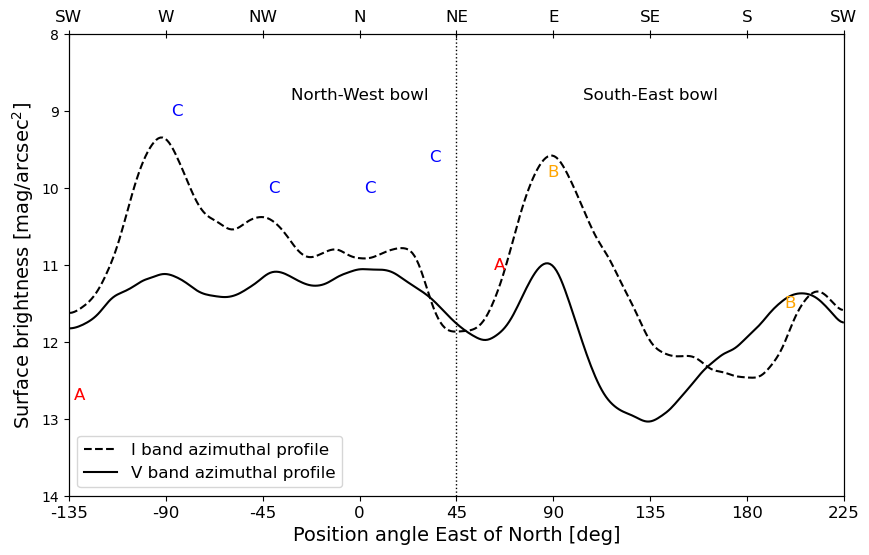

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

# --- Parameters ---
annulus_tolerance = 1
target_radius = 48.6
n_neighbors = 2
bin_width = 1.0
plate_scale_mas_per_px = 3.6
floor_value = 1e-15
smooth_sigma = 3  # in bins

# --- Step 1: Mask annulus and get coordinates ---
annulus_mask = (radii >= target_radius - annulus_tolerance) & (radii <= target_radius + annulus_tolerance)
y_idx, x_idx = np.where(annulus_mask)
coords = np.vstack((x_idx, y_idx)).T

# Get flux and position angle
I_data_cp = I_data / 4.0
flux_valuesI = I_data_cp[annulus_mask]
V_data_cp = V_data / 4.0
flux_valuesV = V_data_cp[annulus_mask]
pa_values = position_angles[annulus_mask]

# --- Step 2: Nearest neighbor smoothing ---
tree = cKDTree(coords)
_, neighbor_indices = tree.query(coords, k=n_neighbors)
smoothed_fluxI = np.array([np.mean(flux_valuesI[inds]) for inds in neighbor_indices])
smoothed_fluxV = np.array([np.mean(flux_valuesV[inds]) for inds in neighbor_indices])

# --- Step 3: Shift PAs ---
pa_shifted = np.copy(pa_values)
pa_shifted[pa_shifted > 225] -= 360

# --- Step 4: Bin by PA ---
bins = np.arange(-135, 225 + bin_width, bin_width)
bin_centers = (bins[:-1] + bins[1:]) / 2
mean_flux_per_binI = np.full_like(bin_centers, np.nan, dtype=np.float64)
mean_flux_per_binV = np.full_like(bin_centers, np.nan, dtype=np.float64)

for i in range(len(bins) - 1):
    mask = (pa_shifted >= bins[i]) & (pa_shifted < bins[i + 1])
    if np.any(mask):
        mean_flux_per_binI[i] = np.mean(smoothed_fluxI[mask])
        mean_flux_per_binV[i] = np.mean(smoothed_fluxV[mask])

# --- Step 5: Interpolate ---
validI = ~np.isnan(mean_flux_per_binI)
interp_func = interp1d(bin_centers[validI], mean_flux_per_binI[validI], kind='linear', fill_value='extrapolate')
mean_flux_interpI = interp_func(bin_centers)

validV = ~np.isnan(mean_flux_per_binV)
interp_func = interp1d(bin_centers[validV], mean_flux_per_binV[validV], kind='linear', fill_value='extrapolate')
mean_flux_interpV = interp_func(bin_centers)

# --- Step 6: Smoothing ---
mean_flux_smoothI = gaussian_filter1d(mean_flux_interpI, sigma=smooth_sigma)
mean_flux_smoothV = gaussian_filter1d(mean_flux_interpV, sigma=smooth_sigma)

# --- Step 7: Convert to surface brightness ---
pixel_area_arcsec2 = (plate_scale_mas_per_px / 1000.0) ** 2

ZP_I = 22.8
I_sb_profile = -2.5 * np.log10(np.maximum(mean_flux_smoothI, floor_value) / pixel_area_arcsec2) + ZP_I
ZP_V = 24.3
V_sb_profile = -2.5 * np.log10(np.maximum(mean_flux_smoothV, floor_value) / pixel_area_arcsec2) + ZP_V

# --- Step 8: Plot ---
fig, ax_profile = plt.subplots(figsize=(10, 6))
ax_profile.plot(bin_centers, I_sb_profile, color='black', linestyle='--', label='I band azimuthal profile')
ax_profile.plot(bin_centers, V_sb_profile, color='black', linestyle='-', label='V band azimuthal profile')

# Axes setup
ax_profile.set_ylabel(r'Surface brightness [mag/arcsec$^2$]', fontsize=14)
ax_profile.set_ylim(8, 14)
ax_profile.invert_yaxis()
ax_profile.set_xlim(-135, 225)
ax_profile.set_xlabel('Position angle East of North [deg]', fontsize=14)
tick_pos = [-135, -90, -45, 0, 45, 90, 135, 180, 225]
ax_profile.set_xticks(tick_pos)
ax_profile.set_xticklabels([str(p) for p in tick_pos], fontsize=12)

# Cardinal direction top axis
ax_top = ax_profile.twiny()
ax_top.set_xlim(ax_profile.get_xlim())
ax_top.set_xticks(tick_pos)
ax_top.set_xticklabels(['SW', 'W', 'NW', 'N', 'NE', 'E', 'SE', 'S', 'SW'], fontsize=12)
ax_top.set_xlabel('')
ax_top.tick_params(axis='x', direction='inout', length=6)

# Annotations
ax_profile.axvline(x=45, color='black', linestyle=':', linewidth=1)
ax_profile.text(0, 8.9, 'North-West bowl', ha='center', va='bottom', fontsize=12)
ax_profile.text(135, 8.9, 'South-East bowl', ha='center', va='bottom', fontsize=12)

# Feature labels
ax_profile.text(65, 11, 'A', color='red', ha='center', va='center', fontsize=12)
ax_profile.text(-130, 12.7, 'A', color='red', ha='center', va='center', fontsize=12)
ax_profile.text(90, 9.8, 'B', color='orange', ha='center', va='center', fontsize=12)
ax_profile.text(200, 11.5, 'B', color='orange', ha='center', va='center', fontsize=12)
ax_profile.text(-85, 9, 'C', color='blue', ha='center', va='center', fontsize=12)
ax_profile.text(-40, 10, 'C', color='blue', ha='center', va='center', fontsize=12)
ax_profile.text(5, 10, 'C', color='blue', ha='center', va='center', fontsize=12)
ax_profile.text(35, 9.6, 'C', color='blue', ha='center', va='center', fontsize=12)

ax_profile.legend(fontsize=12, loc='lower left')
ax_profile.grid(False)
ax_profile.set_facecolor('white')

plt.show()


In [51]:
noise_flux = 0.5
m_limit = 25.0  # magnitude assigned to noise limit

ZP = m_limit + 2.5 * np.log10(noise_flux)
print(f"Estimated ZP: {ZP:.2f}")

Estimated ZP: 24.25


### 2018 Data DEO

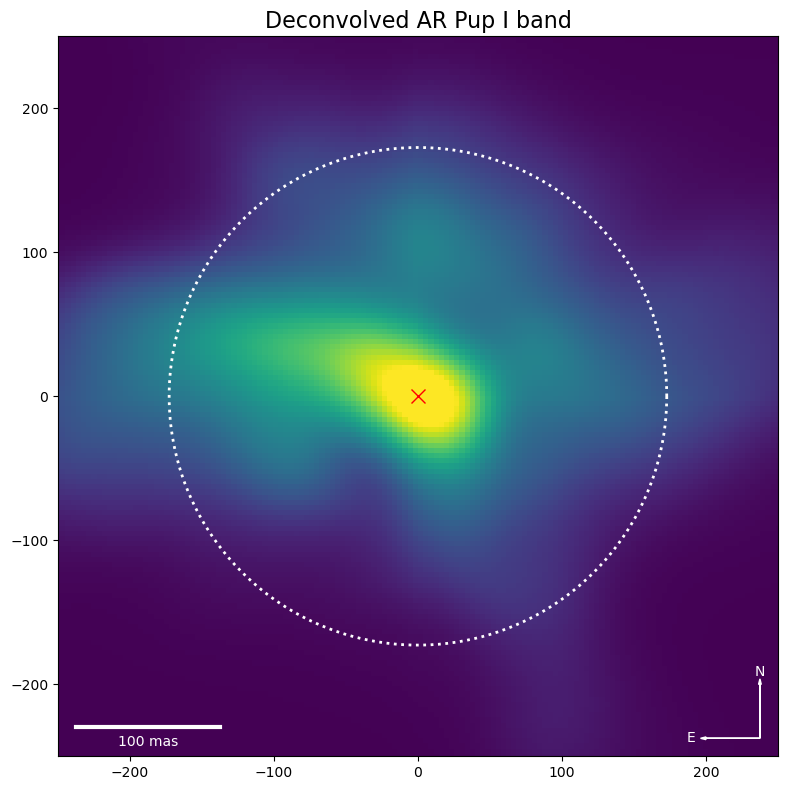

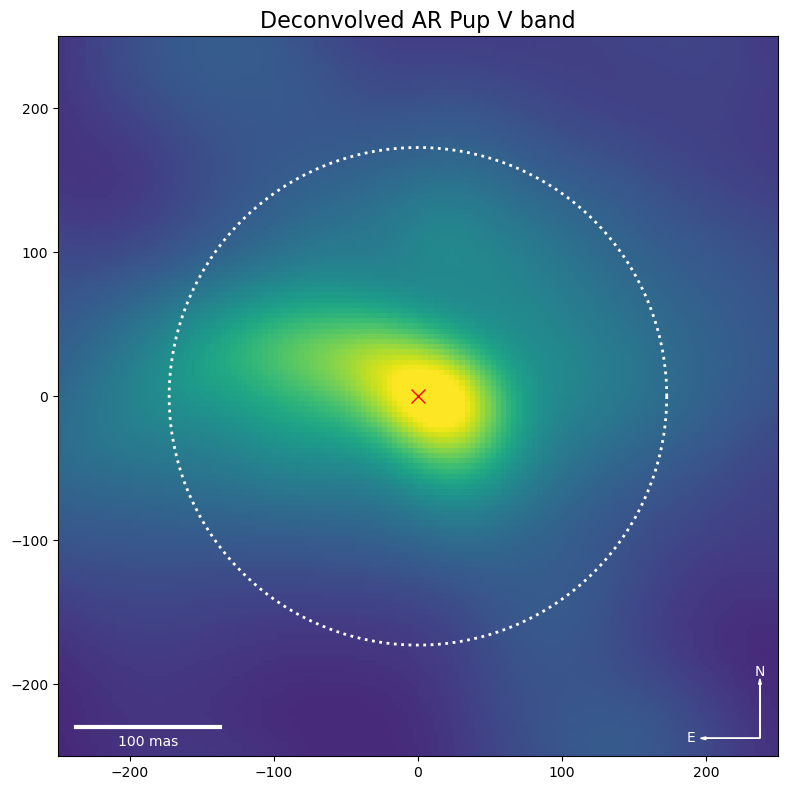

In [56]:
zoom_half_width_mas = 250

fits_file_I_2018 = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Deconvolution_corr_telv1/ZIMPOLv2/deconvolved_I/01.SCI_AR_Pup_I_decon.fits'
fits_file_V_2018 = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Deconvolution_corr_tel/ZIMPOL/deconvolved_I/01.SCI_AR_Pup_V_decon.fits'

plate_scale_mas_per_px = 3.6 # mas/pixel
separation_pixels = 48     # Distance from peak for azimuthal profile
separation_mas = separation_pixels * plate_scale_mas_per_px
photometric_zero_point = 24.8 # Placeholder: magnitude zero point

I_data, I_header = load_fits_image(fits_file_I_2018)
I_data = rotate(I_data, angle=0, reshape=False, order=3)

V_data, V_header = load_fits_image(fits_file_V_2018)
V_data = rotate(V_data, angle=0, reshape=False, order=3)

# Get image dimensions (assuming I and V have same dimensions)
ny, nx = I_data.shape
if ny != nx:
    print("Warning: Image is not square. Code assumes square images.")

coords = find_peaks(I_data, np.max(I_data)*0.5, npeaks=1) # find_peaks threshold needs adjusting
if len(coords) < 0:
    peak_y, peak_x = int(coords['y_peak'][0]), int(coords['x_peak'][0])
else:
    print("Warning: Could not find a clear peak in I-band. Assuming image center for now.")
    peak_y, peak_x = ny // 2, nx // 2

# Create coordinate grids centered on the peak
x_coords = np.arange(nx) - peak_x
y_coords = np.arange(ny) - peak_y
X_grid, Y_grid = np.meshgrid(x_coords, y_coords)

# Convert to polar coordinates relative to the peak
radii, position_angles = cart2polar_for_mask_defining(X_grid, Y_grid)

# --- Extract Azimuthal Profiles ---
# Find pixels that are within a small radial tolerance around the desired separation
annulus_tolerance = 2 # pixels, defines the half-width of the annulus
azimuthal_mask = (radii >= separation_pixels - annulus_tolerance) & \
                 (radii < separation_pixels + annulus_tolerance)

# Extract data points within the annulus for I-band
I_data = crop_centered(I_data,194,194)
V_data = crop_centered(V_data,194,194)
I_annulus_values = I_data[azimuthal_mask]
V_annulus_values = V_data[azimuthal_mask]

pa_annulus_values = position_angles[azimuthal_mask]

# Sort by position angle to get a coherent profile
sort_indices = np.argsort(pa_annulus_values)
pa_sorted = pa_annulus_values[sort_indices]
I_sorted = I_annulus_values[sort_indices]
V_sorted = V_annulus_values[sort_indices]

# --- Convert to Surface Brightness (Magnitude/as^2) ---
pixel_area_arcsec2 = (plate_scale_mas_per_px / 1000.0)**2
floor_value = 1e-15 # very small positive number to avoid log10(0)
I_surface_brightness = -2.5 * np.log10(I_sorted/pixel_area_arcsec2) + 25.0
V_surface_brightness = -2.5 * np.log10(I_sorted/pixel_area_arcsec2) + 25.0


# --- Plotting the Azimuthal Profiles (I and V on the same graph) ---
# fig_profile, ax_profile = plt.subplots(figsize=(10, 6))
# ax_profile.plot(pa_sorted, I_surface_brightness, label='I Band (Total Intensity)', color='blue')
#
# ax_profile.set_xlabel('Position Angle East of North (deg)', fontsize=14)
# ax_profile.set_ylabel(r'Surface Brightness (mag/arcsec$^2$)', fontsize=14)
# ax_profile.set_title(f'Azimuthal Profile at {separation_mas:.0f} mas from Peak (I and V Bands)', fontsize=16)
# ax_profile.legend(fontsize=12)
# ax_profile.grid(True, linestyle=':', alpha=0.7)
# ax_profile.set_xlim(0, 360) # Ensure full 0-360 range
# ax_profile.set_xticks(np.arange(0, 361, 45)) # Ticks every 45 degrees
#
# plt.tight_layout()
# plt.show()
# plt.close(fig_profile)

# Save overlay image for I band
output_image_I = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/After_deconvv1/ZIMPOL/i_azimuthal_circle.png'
# output_image_I = output_image_with_circle.replace("v_band", "i_band")
plot_circle_overlay(I_data, 'I', output_image_I,
                    peak_x, peak_y,
                    plate_scale_mas_per_px,
                    separation_pixels,
                    250)
plt.show()

output_image_V = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/After_deconvv1/ZIMPOL/v_azimuthal_circle.png'
# output_image_I = output_image_with_circle.replace("v_band", "i_band")
plot_circle_overlay(V_data, 'V', output_image_V,
                    peak_x, peak_y,
                    plate_scale_mas_per_px,
                    separation_pixels,
                    250)
plt.show()

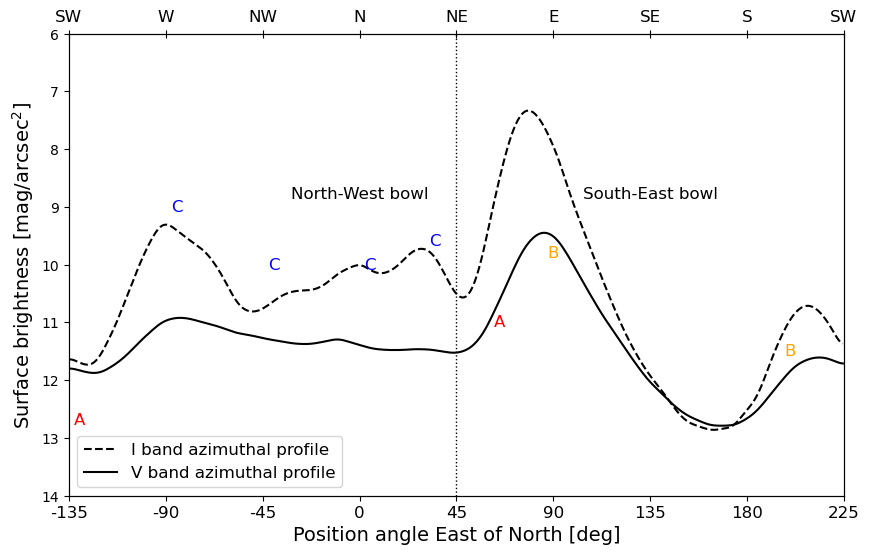

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

# --- Parameters ---
annulus_tolerance = 1
target_radius = 48.6
n_neighbors = 2
bin_width = 1.0
plate_scale_mas_per_px = 3.6
floor_value = 1e-15
smooth_sigma = 3  # in bins

# --- Step 1: Mask annulus and get coordinates ---
annulus_mask = (radii >= target_radius - annulus_tolerance) & (radii <= target_radius + annulus_tolerance)
y_idx, x_idx = np.where(annulus_mask)
coords = np.vstack((x_idx, y_idx)).T

# Get flux and position angle
I_data_cp = I_data / 4.0
flux_valuesI = I_data_cp[annulus_mask]
V_data_cp = V_data / 4.0
flux_valuesV = V_data_cp[annulus_mask]
pa_values = position_angles[annulus_mask]

# --- Step 2: Nearest neighbor smoothing ---
tree = cKDTree(coords)
_, neighbor_indices = tree.query(coords, k=n_neighbors)
smoothed_fluxI = np.array([np.mean(flux_valuesI[inds]) for inds in neighbor_indices])
smoothed_fluxV = np.array([np.mean(flux_valuesV[inds]) for inds in neighbor_indices])

# --- Step 3: Shift PAs ---
pa_shifted = np.copy(pa_values)
pa_shifted[pa_shifted > 225] -= 360

# --- Step 4: Bin by each PA ---
bins = np.arange(-135, 225 + bin_width, bin_width)
bin_centers = (bins[:-1] + bins[1:]) / 2
mean_flux_per_binI = np.full_like(bin_centers, np.nan, dtype=np.float64)
mean_flux_per_binV = np.full_like(bin_centers, np.nan, dtype=np.float64)

for i in range(len(bins) - 1):
    mask = (pa_shifted >= bins[i]) & (pa_shifted < bins[i + 1])
    if np.any(mask):
        mean_flux_per_binI[i] = np.mean(smoothed_fluxI[mask])
        mean_flux_per_binV[i] = np.mean(smoothed_fluxV[mask])

# --- Step 5: Interpolate ---
validI = ~np.isnan(mean_flux_per_binI)
interp_func = interp1d(bin_centers[validI], mean_flux_per_binI[validI], kind='linear', fill_value='extrapolate')
mean_flux_interpI = interp_func(bin_centers)

validV = ~np.isnan(mean_flux_per_binV)
interp_func = interp1d(bin_centers[validV], mean_flux_per_binV[validV], kind='linear', fill_value='extrapolate')
mean_flux_interpV = interp_func(bin_centers)

# --- Step 6: Smoothing for nicer curve ---
mean_flux_smoothI = gaussian_filter1d(mean_flux_interpI, sigma=smooth_sigma)
mean_flux_smoothV = gaussian_filter1d(mean_flux_interpV, sigma=smooth_sigma)

# --- Step 7: Convert to surface brightness ---
pixel_area_arcsec2 = (plate_scale_mas_per_px / 1000.0) ** 2

ZP_I = 21.8
I_sb_profile = -2.5 * np.log10(np.maximum(mean_flux_smoothI, floor_value) / pixel_area_arcsec2) + ZP_I
ZP_V = 24.3
V_sb_profile = -2.5 * np.log10(np.maximum(mean_flux_smoothV, floor_value) / pixel_area_arcsec2) + ZP_V

# --- Step 8: Plot ---
fig, ax_profile = plt.subplots(figsize=(10, 6))
ax_profile.plot(bin_centers, I_sb_profile, color='black', linestyle='--', label='I band azimuthal profile')
ax_profile.plot(bin_centers, V_sb_profile, color='black', linestyle='-', label='V band azimuthal profile')

# Axes setup
ax_profile.set_ylabel(r'Surface brightness [mag/arcsec$^2$]', fontsize=14)
ax_profile.set_ylim(6, 14)
ax_profile.invert_yaxis()
ax_profile.set_xlim(-135, 225)
ax_profile.set_xlabel('Position angle East of North [deg]', fontsize=14)
tick_pos = [-135, -90, -45, 0, 45, 90, 135, 180, 225]
ax_profile.set_xticks(tick_pos)
ax_profile.set_xticklabels([str(p) for p in tick_pos], fontsize=12)

# Cardinal direction top axis
ax_top = ax_profile.twiny()
ax_top.set_xlim(ax_profile.get_xlim())
ax_top.set_xticks(tick_pos)
ax_top.set_xticklabels(['SW', 'W', 'NW', 'N', 'NE', 'E', 'SE', 'S', 'SW'], fontsize=12)
ax_top.set_xlabel('')
ax_top.tick_params(axis='x', direction='inout', length=6)

# Annotations
ax_profile.axvline(x=45, color='black', linestyle=':', linewidth=1)
ax_profile.text(0, 8.9, 'North-West bowl', ha='center', va='bottom', fontsize=12)
ax_profile.text(135, 8.9, 'South-East bowl', ha='center', va='bottom', fontsize=12)

# Feature labels
ax_profile.text(65, 11, 'A', color='red', ha='center', va='center', fontsize=12)
ax_profile.text(-130, 12.7, 'A', color='red', ha='center', va='center', fontsize=12)
ax_profile.text(90, 9.8, 'B', color='orange', ha='center', va='center', fontsize=12)
ax_profile.text(200, 11.5, 'B', color='orange', ha='center', va='center', fontsize=12)
ax_profile.text(-85, 9, 'C', color='blue', ha='center', va='center', fontsize=12)
ax_profile.text(-40, 10, 'C', color='blue', ha='center', va='center', fontsize=12)
ax_profile.text(5, 10, 'C', color='blue', ha='center', va='center', fontsize=12)
ax_profile.text(35, 9.6, 'C', color='blue', ha='center', va='center', fontsize=12)

ax_profile.legend(fontsize=12, loc='lower left')
ax_profile.grid(False)
ax_profile.set_facecolor('white')

plt.show()


In [108]:
mags = -2.5 * np.log10(np.maximum(np.max(I_data_cp), floor_value) / pixel_area_arcsec2)
# print(mags)

In [109]:
-mags

np.float64(21.39414602819609)